In [2]:
!pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 26.0 MB/s eta 0:00:00


In [3]:
# Import necessary packages
import torch
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning import LightningModule, Trainer, seed_everything
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import EarlyStopping

In [4]:
import pandas as pd
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')




Mounted at /content/drive


In [5]:
!ls "/content/drive/My Drive/Colab Notebooks"

 all_train.csv.gz		   'Copy of ML Project 1.ipynb'  'HW6 sample.ipynb'
'Case Study 6_Anish_Tuning.ipynb'  'HW6 sample1.ipynb'		  Untitled0.ipynb


In [6]:
data = pd.read_csv("/content/drive/My Drive/all_train.csv.gz", compression='gzip', nrows=100000)

In [7]:
X = data.iloc[:, 1:]  # Features: f0 to f26 + 'mass'
y = data.iloc[:, 0]   # Target variable

# Split data for training and validation
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=100)

# Scale the data
scaler = StandardScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train), columns=x_train.columns)
x_test = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)

In [8]:
# Define the PyTorch Dataset class
class HWDataset(Dataset):
    def __init__(self, X_dataFrame, y_dataFrame):
        self.X = X_dataFrame
        self.y = y_dataFrame

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        inputs = torch.tensor(self.X.iloc[idx, :]).float()
        targets = torch.tensor(self.y.iloc[idx]).float()
        return inputs, targets

In [11]:
# Create DataLoaders for the tuning phase
train_data = HWDataset(x_train, y_train)
valid_data = HWDataset(x_test, y_test)
train_dataloader = DataLoader(train_data, batch_size=256, shuffle=True, num_workers=4)
test_dataloader = DataLoader(valid_data, batch_size=256, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [12]:
# Define the PyTorch Lightning model for tuning
class BigModel(LightningModule):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(28, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
        self.loss = nn.BCELoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.loss(y_hat.squeeze(), y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.loss(y_hat.squeeze(), y)
        self.log("val_loss", loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-4)

In [13]:
# Set up CSV logger and early stopping for tuning
csv_logger = CSVLogger(save_dir='logs', name='tuning_logs')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')

In [14]:
# Train the model on the smaller sample for tuning
trainer = Trainer(
    max_epochs=10,
    logger=csv_logger,
    callbacks=[early_stopping],
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1  # Use 1 device whether GPU or CPU
)
model = BigModel()
trainer.fit(model, train_dataloader, test_dataloader)



INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 146 K  | train
1 | loss  | BCELoss    | 0      | train
---------------------------------------------
146 K     Trainable params
0         Non-trainable params
146 K     Total params
0.586     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

<ipython-input-10-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-10-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-10-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-10-3b88db18e08e>:11: F

Training: |          | 0/? [00:00<?, ?it/s]

<ipython-input-10-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-10-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-10-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-10-3b88db18e08e>:11: F

Validation: |          | 0/? [00:00<?, ?it/s]

<ipython-input-10-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-10-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-10-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-10-3b88db18e08e>:11: F

Validation: |          | 0/? [00:00<?, ?it/s]

<ipython-input-10-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-10-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-10-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-10-3b88db18e08e>:11: F

Validation: |          | 0/? [00:00<?, ?it/s]

<ipython-input-10-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-10-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-10-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-10-3b88db18e08e>:11: F

Validation: |          | 0/? [00:00<?, ?it/s]

<ipython-input-10-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-10-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-10-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-10-3b88db18e08e>:11: F

Validation: |          | 0/? [00:00<?, ?it/s]

<ipython-input-10-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-10-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-10-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-10-3b88db18e08e>:11: F

Validation: |          | 0/? [00:00<?, ?it/s]

<ipython-input-10-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-10-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-10-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-10-3b88db18e08e>:11: F

Validation: |          | 0/? [00:00<?, ?it/s]

<ipython-input-10-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-10-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-10-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-10-3b88db18e08e>:11: F

Validation: |          | 0/? [00:00<?, ?it/s]

<ipython-input-10-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-10-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-10-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-10-3b88db18e08e>:11: F

Validation: |          | 0/? [00:00<?, ?it/s]

<ipython-input-10-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-10-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-10-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-10-3b88db18e08e>:11: F

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [14]:
# Get a batch of data from the train or test DataLoader
for inputs, targets in test_dataloader:
    break  # Load just one batch for testing

# Now, 'inputs' contains the input data and can be used with your model


<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-8-3b88db18e08e>:11: Futur

In [16]:
# Make predictions on the inputs
outputs = model.model(inputs).squeeze()
predictions = outputs.round()  # Convert probabilities to class labels (0 or 1)
print("Predictions:", predictions)


Predictions: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.,

In [17]:
from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(targets.numpy(), predictions.detach().numpy())
print("Accuracy of the model on the test batch:", accuracy)

Accuracy of the model on the test batch: 0.517


# **1) Parameter with batch size = 500 and num_workers at 5**

In [22]:
# Create DataLoaders for the tuning phase
train_data = HWDataset(x_train, y_train)
valid_data = HWDataset(x_test, y_test)
train_dataloader = DataLoader(train_data, batch_size=500, shuffle=True, num_workers=5)
test_dataloader = DataLoader(valid_data, batch_size=500, shuffle=False, num_workers=5)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [23]:
class BigModel(LightningModule):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(28, 1000),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1000, 1000),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1000, 1),
            nn.Sigmoid()  # Use Sigmoid if you're using BCELoss
        )
        self.loss = nn.BCELoss()  # Use BCEWithLogitsLoss if you remove the Sigmoid()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.loss(y_hat.squeeze(), y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.loss(y_hat.squeeze(), y)
        self.log("val_loss", loss)
        acc = accuracy_score(y.detach().cpu(), (y_hat.detach().cpu().squeeze() > 0.5).int())
        self.log("val_acc", acc)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-4)


In [24]:
csv_logger = CSVLogger(save_dir='logs', name='tuning_logs1')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')


In [25]:
trainer = Trainer(
    max_epochs=10,
    logger=csv_logger,
    callbacks=[early_stopping],
    devices=1 if torch.cuda.is_available() else 1,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu'
)

model = BigModel()
trainer.fit(model, train_dataloader, test_dataloader)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 1.0 M  | train
1 | loss  | BCELoss    | 0      | train
---------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.124     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

<ipython-input-10-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-10-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-10-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-10-3b88db18e08e>:11: F

Training: |          | 0/? [00:00<?, ?it/s]

<ipython-input-10-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-10-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-10-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-10-3b88db18e08e>:11: F

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-10-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-10-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acce

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-10-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-10-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acce

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-10-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-10-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acce

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-10-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-10-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acce

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-10-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-10-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acce

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-10-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-10-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acce

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-10-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-10-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acce

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-10-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-10-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acce

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-10-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-10-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acce

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-10-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-10-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acce

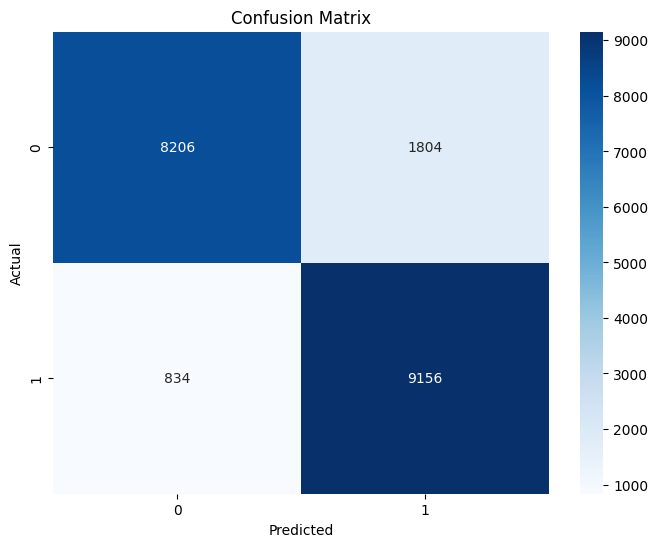

In [26]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions on the test set
predictions = []
targets = []

model.eval()
with torch.no_grad():
    for batch in test_dataloader:
        x, y = batch
        y_hat = model(x)
        predictions.extend((y_hat.squeeze() > 0.5).int().tolist())
        targets.extend(y.tolist())

# Plot confusion matrix
cm = confusion_matrix(targets, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


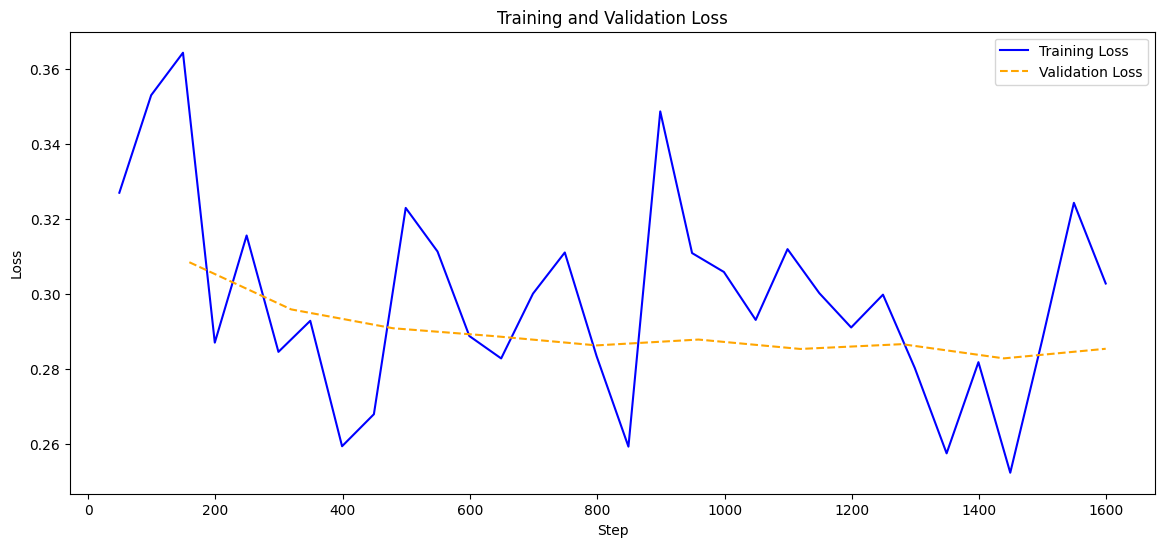

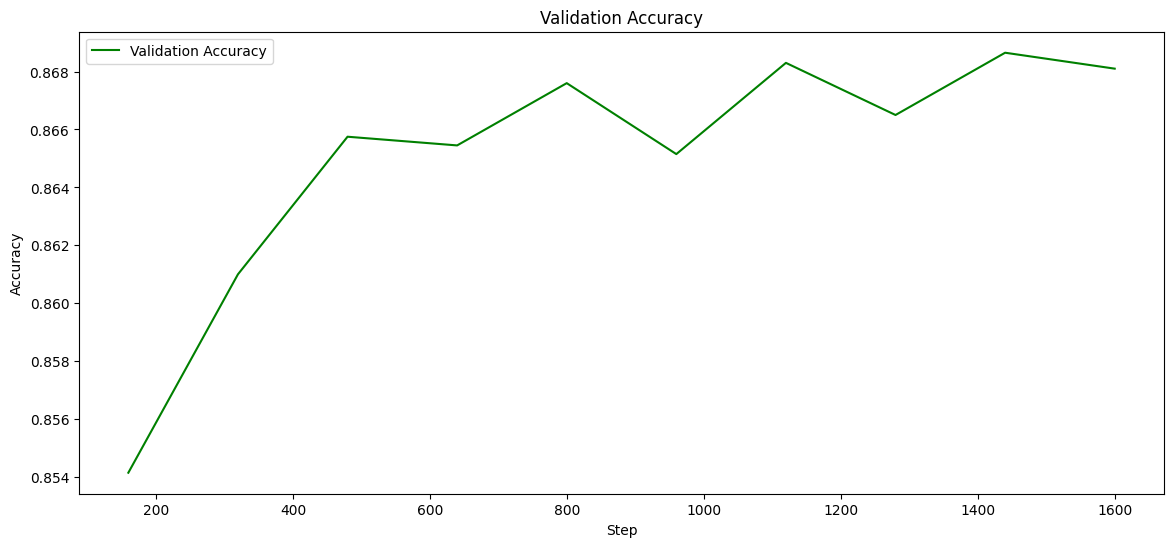

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the metrics CSV file
metrics = pd.read_csv('logs/tuning_logs1/version_0/metrics.csv')

# Plot training and validation loss
plt.figure(figsize=(14, 6))
plt.plot(metrics['step'][metrics['train_loss'].notna()], metrics['train_loss'].dropna(), label='Training Loss', color='blue')
plt.plot(metrics['step'][metrics['val_loss'].notna()], metrics['val_loss'].dropna(), label='Validation Loss', color='orange', linestyle='--')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot validation accuracy
plt.figure(figsize=(14, 6))
plt.plot(metrics['step'][metrics['val_acc'].notna()], metrics['val_acc'].dropna(), label='Validation Accuracy', color='green')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()


#**2) Batch size = 1000 , num_workers = 5**

In [40]:
# Create DataLoaders for the tuning phase
train_data = HWDataset(x_train, y_train)
valid_data = HWDataset(x_test, y_test)
train_dataloader = DataLoader(train_data, batch_size=1000, shuffle=True, num_workers=5)
test_dataloader = DataLoader(valid_data, batch_size=1000, shuffle=False, num_workers=5)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [41]:
class BigModel(LightningModule):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(28, 1000),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1000, 1000),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1000, 1),
            nn.Sigmoid()  # Use Sigmoid if you're using BCELoss
        )
        self.loss = nn.BCELoss()  # Use BCEWithLogitsLoss if you remove the Sigmoid()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.loss(y_hat.squeeze(), y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.loss(y_hat.squeeze(), y)
        self.log("val_loss", loss)
        acc = accuracy_score(y.detach().cpu(), (y_hat.detach().cpu().squeeze() > 0.5).int())
        self.log("val_acc", acc)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-4)

In [42]:
csv_logger = CSVLogger(save_dir='logs', name='tuning_logs2')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')

In [43]:
trainer = Trainer(
    max_epochs=10,
    logger=csv_logger,
    callbacks=[early_stopping],
    devices=1 if torch.cuda.is_available() else 1,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu'
)

model = BigModel()
trainer.fit(model, train_dataloader, test_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 1.0 M  | train
1 | loss  | BCELoss    | 0      | train
---------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.124     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

<ipython-input-10-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-10-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-10-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-10-3b88db18e08e>:11: F

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

Exception ignored in: <function Profiler.__del__ at 0x785b95c425f0>

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions on the test set
predictions = []
targets = []

model.eval()
with torch.no_grad():
    for batch in test_dataloader:
        x, y = batch
        y_hat = model(x)
        predictions.extend((y_hat.squeeze() > 0.5).int().tolist())
        targets.extend(y.tolist())

# Plot confusion matrix
cm = confusion_matrix(targets, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the metrics CSV file
metrics = pd.read_csv('logs/tuning_logs2/version_0/metrics.csv')

# Plot training and validation loss
plt.figure(figsize=(14, 6))
plt.plot(metrics['step'][metrics['train_loss'].notna()], metrics['train_loss'].dropna(), label='Training Loss', color='blue')
plt.plot(metrics['step'][metrics['val_loss'].notna()], metrics['val_loss'].dropna(), label='Validation Loss', color='orange', linestyle='--')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot validation accuracy
plt.figure(figsize=(14, 6))
plt.plot(metrics['step'][metrics['val_acc'].notna()], metrics['val_acc'].dropna(), label='Validation Accuracy', color='green')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()


**# 3) Batch size = 1000, num_workers = 10**

In [ ]:
# Create DataLoaders for the tuning phase
train_data = HWDataset(x_train, y_train)
valid_data = HWDataset(x_test, y_test)
train_dataloader = DataLoader(train_data, batch_size=1000, shuffle=True, num_workers=10)
test_dataloader = DataLoader(valid_data, batch_size=1000, shuffle=False, num_workers=10)

In [ ]:
class BigModel(LightningModule):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(28, 1000),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1000, 1000),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1000, 1),
            nn.Sigmoid()  # Use Sigmoid if you're using BCELoss
        )
        self.loss = nn.BCELoss()  # Use BCEWithLogitsLoss if you remove the Sigmoid()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.loss(y_hat.squeeze(), y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.loss(y_hat.squeeze(), y)
        self.log("val_loss", loss)
        acc = accuracy_score(y.detach().cpu(), (y_hat.detach().cpu().squeeze() > 0.5).int())
        self.log("val_acc", acc)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-4)

In [ ]:
csv_logger = CSVLogger(save_dir='logs', name='tuning_logs3')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')

In [ ]:
trainer = Trainer(
    max_epochs=10,
    logger=csv_logger,
    callbacks=[early_stopping],
    devices=1 if torch.cuda.is_available() else 1,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu'
)

model = BigModel()
trainer.fit(model, train_dataloader, test_dataloader)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions on the test set
predictions = []
targets = []

model.eval()
with torch.no_grad():
    for batch in test_dataloader:
        x, y = batch
        y_hat = model(x)
        predictions.extend((y_hat.squeeze() > 0.5).int().tolist())
        targets.extend(y.tolist())

# Plot confusion matrix
cm = confusion_matrix(targets, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the metrics CSV file
metrics = pd.read_csv('logs/tuning_logs3/version_0/metrics.csv')

# Plot training and validation loss
plt.figure(figsize=(14, 6))
plt.plot(metrics['step'][metrics['train_loss'].notna()], metrics['train_loss'].dropna(), label='Training Loss', color='blue')
plt.plot(metrics['step'][metrics['val_loss'].notna()], metrics['val_loss'].dropna(), label='Validation Loss', color='orange', linestyle='--')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot validation accuracy
plt.figure(figsize=(14, 6))
plt.plot(metrics['step'][metrics['val_acc'].notna()], metrics['val_acc'].dropna(), label='Validation Accuracy', color='green')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

# 4)

In [9]:
# Create DataLoaders for the tuning phase
train_data = HWDataset(x_train, y_train)
valid_data = HWDataset(x_test, y_test)
train_dataloader = DataLoader(train_data, batch_size=1000, shuffle=True, num_workers=10)
test_dataloader = DataLoader(valid_data, batch_size=1000, shuffle=False, num_workers=10)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [18]:
class BigModel(LightningModule):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(28, 1000),  # Input to first hidden layer
            nn.ReLU(),
            nn.Dropout(0.3),  # Dropout with 30% probability to prevent overfitting
            nn.Linear(1000, 1000),  # Second hidden layer
            nn.ReLU(),
            nn.Dropout(0.3),  # Dropout with 30% probability
            nn.Linear(1000, 1000),  # Third hidden layer
            nn.ReLU(),
            nn.Dropout(0.2),  # Dropout with 20% probability
            nn.Linear(1000, 1000),  # Fourth hidden layer
            nn.ReLU(),
            nn.Dropout(0.2),  # Dropout with 20% probability
            nn.Linear(1000, 1),  # Final output layer
            nn.Sigmoid()  # Use Sigmoid if you're using BCELoss
        )
        self.loss = nn.BCELoss()  # Use BCEWithLogitsLoss if you remove the Sigmoid()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.loss(y_hat.squeeze(), y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.loss(y_hat.squeeze(), y)
        self.log("val_loss", loss)
        acc = accuracy_score(y.detach().cpu(), (y_hat.detach().cpu().squeeze() > 0.5).int())
        self.log("val_acc", acc)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-4)


In [11]:
csv_logger = CSVLogger(save_dir='logs', name='tuning_logs4')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')

In [19]:
trainer = Trainer(
    max_epochs=10,
    logger=csv_logger,
    callbacks=[early_stopping],
    devices=1 if torch.cuda.is_available() else 1,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu'
)

model = BigModel()
trainer.fit(model, train_dataloader, test_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 3.0 M  | train
1 | loss  | BCELoss    | 0      | train
---------------------------------------------
3.0 M     Trainable params
0         Non-trainable params
3.0 M     Total params
12.132    Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acces

Training: |          | 0/? [00:00<?, ?it/s]

<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-8-3b88db18e08e>:11: Futur

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acces

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acces

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acces

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acces

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acces

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acces

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acces

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acces

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acces

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acces

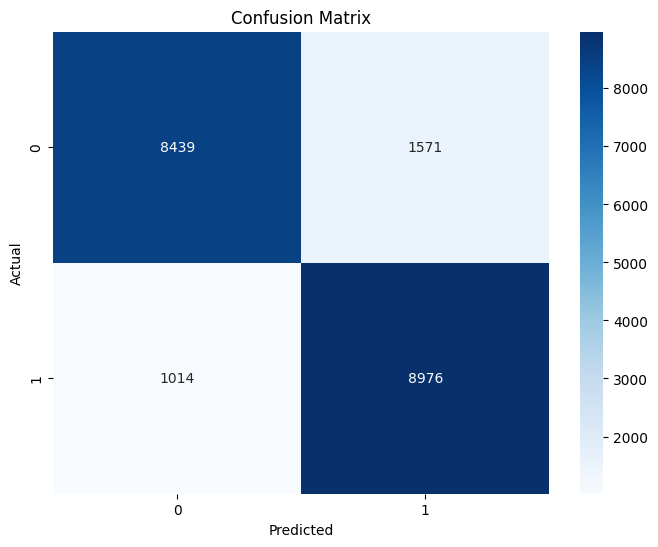

In [20]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions on the test set
predictions = []
targets = []

model.eval()
with torch.no_grad():
    for batch in test_dataloader:
        x, y = batch
        y_hat = model(x)
        predictions.extend((y_hat.squeeze() > 0.5).int().tolist())
        targets.extend(y.tolist())

# Plot confusion matrix
cm = confusion_matrix(targets, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

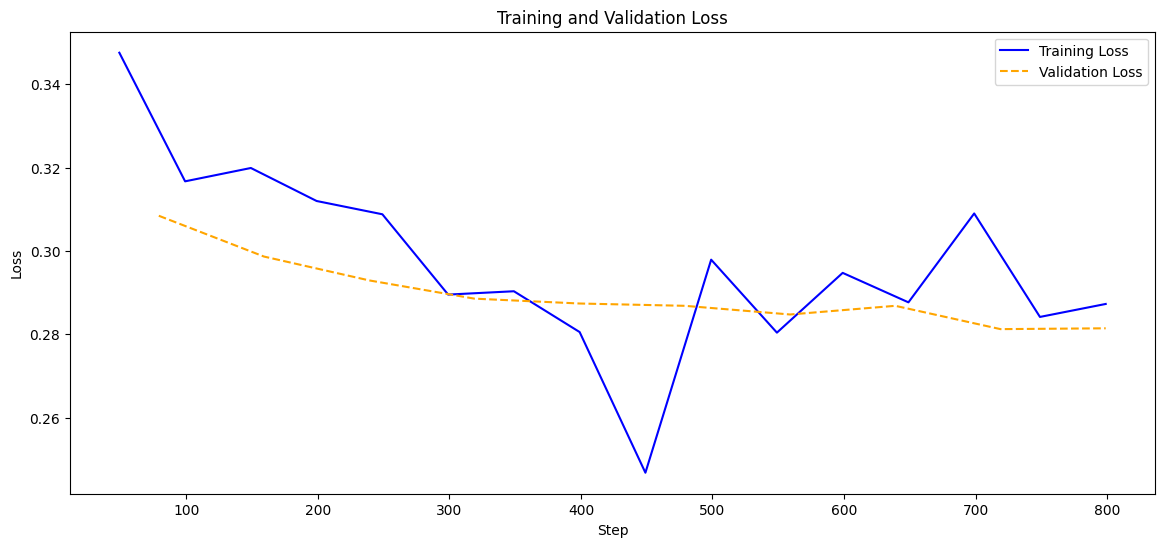

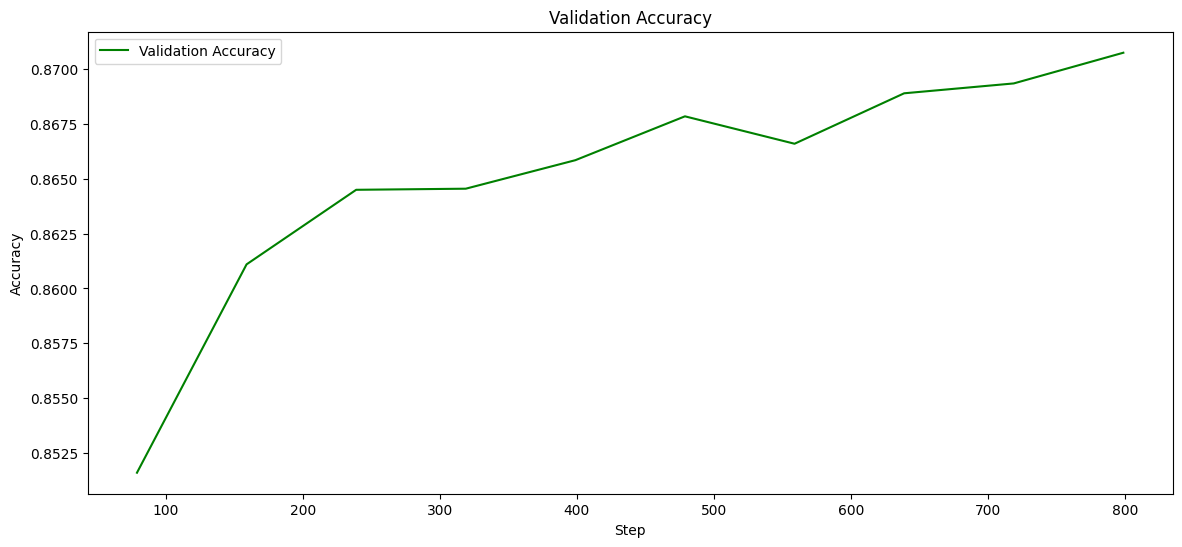

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the metrics CSV file
metrics = pd.read_csv('logs/tuning_logs4/version_0/metrics.csv')

# Plot training and validation loss
plt.figure(figsize=(14, 6))
plt.plot(metrics['step'][metrics['train_loss'].notna()], metrics['train_loss'].dropna(), label='Training Loss', color='blue')
plt.plot(metrics['step'][metrics['val_loss'].notna()], metrics['val_loss'].dropna(), label='Validation Loss', color='orange', linestyle='--')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot validation accuracy
plt.figure(figsize=(14, 6))
plt.plot(metrics['step'][metrics['val_acc'].notna()], metrics['val_acc'].dropna(), label='Validation Accuracy', color='green')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

# 5) Without regularization

In [23]:
# Create DataLoaders for the tuning phase
train_data = HWDataset(x_train, y_train)
valid_data = HWDataset(x_test, y_test)
train_dataloader = DataLoader(train_data, batch_size=1000, shuffle=True, num_workers=10)
test_dataloader = DataLoader(valid_data, batch_size=1000, shuffle=False, num_workers=10)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [24]:
class BigModel(LightningModule):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(28, 1000),  # Input to first hidden layer
            nn.ReLU(),
            nn.Linear(1000, 1000),  # Second hidden layer
            nn.ReLU(),
            nn.Linear(1000, 1000),  # Third hidden layer
            nn.ReLU(),
            nn.Linear(1000, 1000),  # Fourth hidden layer
            nn.ReLU(),
            nn.Linear(1000, 1),  # Final output layer
            nn.Sigmoid()  # Use Sigmoid if you're using BCELoss
        )
        self.loss = nn.BCELoss()  # Use BCEWithLogitsLoss if you remove the Sigmoid()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.loss(y_hat.squeeze(), y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.loss(y_hat.squeeze(), y)
        self.log("val_loss", loss)
        acc = accuracy_score(y.detach().cpu(), (y_hat.detach().cpu().squeeze() > 0.5).int())
        self.log("val_acc", acc)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-4)


In [25]:
csv_logger = CSVLogger(save_dir='logs', name='tuning_logs5')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')

In [26]:
trainer = Trainer(
    max_epochs=10,
    logger=csv_logger,
    callbacks=[early_stopping],
    devices=1 if torch.cuda.is_available() else 1,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu'
)

model = BigModel()
trainer.fit(model, train_dataloader, test_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 3.0 M  | train
1 | loss  | BCELoss    | 0      | train
---------------------------------------------
3.0 M     Trainable params
0         Non-trainable params
3.0 M     Total params
12.132    Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-8-3b88db18e08e>:11: Futur

Training: |          | 0/? [00:00<?, ?it/s]

<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-8-3b88db18e08e>:11: Futur

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acces

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acces

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acces

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acces

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acces

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acces

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acces

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acces

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acces

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions on the test set
predictions = []
targets = []

model.eval()
with torch.no_grad():
    for batch in test_dataloader:
        x, y = batch
        y_hat = model(x)
        predictions.extend((y_hat.squeeze() > 0.5).int().tolist())
        targets.extend(y.tolist())

# Plot confusion matrix
cm = confusion_matrix(targets, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

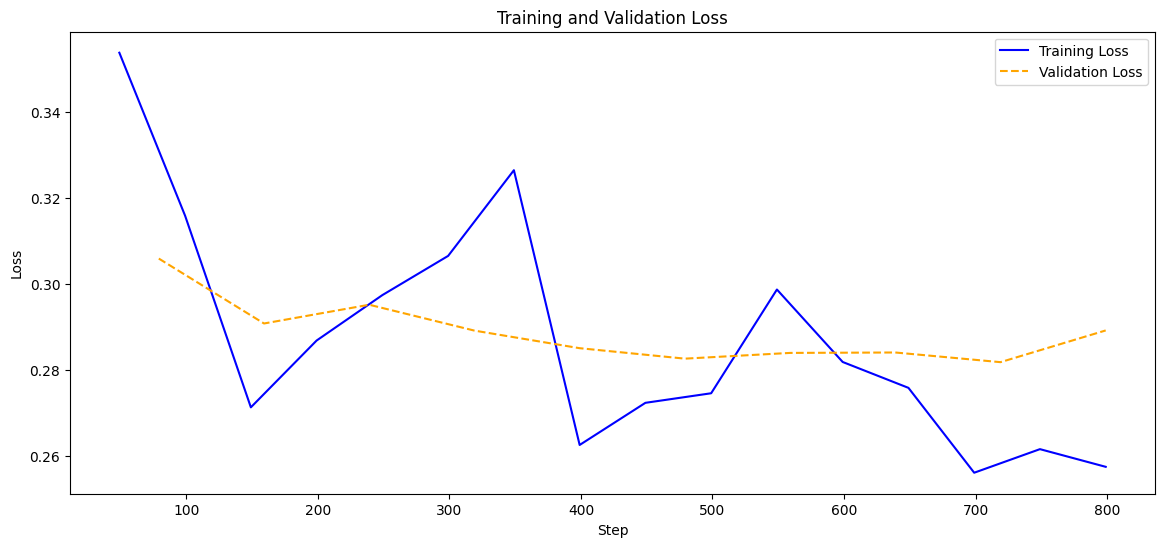

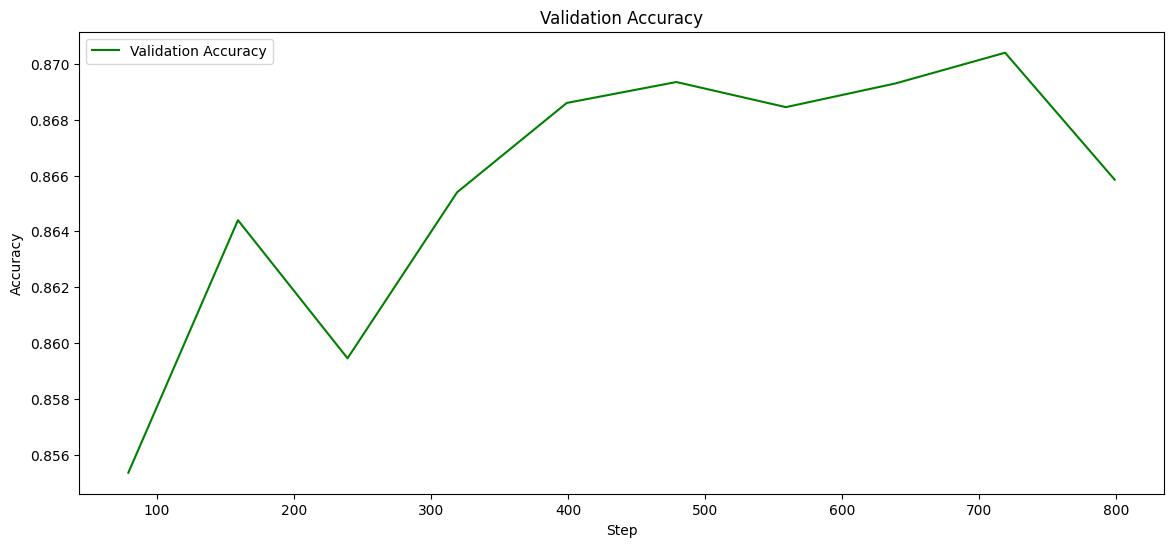

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the metrics CSV file
metrics = pd.read_csv('logs/tuning_logs5/version_0/metrics.csv')

# Plot training and validation loss
plt.figure(figsize=(14, 6))
plt.plot(metrics['step'][metrics['train_loss'].notna()], metrics['train_loss'].dropna(), label='Training Loss', color='blue')
plt.plot(metrics['step'][metrics['val_loss'].notna()], metrics['val_loss'].dropna(), label='Validation Loss', color='orange', linestyle='--')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot validation accuracy
plt.figure(figsize=(14, 6))
plt.plot(metrics['step'][metrics['val_acc'].notna()], metrics['val_acc'].dropna(), label='Validation Accuracy', color='green')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

**# 6) Different Activation Fuction LeakyReLU**

In [28]:
# Create DataLoaders for the tuning phase
train_data = HWDataset(x_train, y_train)
valid_data = HWDataset(x_test, y_test)
train_dataloader = DataLoader(train_data, batch_size=1000, shuffle=True, num_workers=10)
test_dataloader = DataLoader(valid_data, batch_size=1000, shuffle=False, num_workers=10)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [29]:
import torch
import torch.nn as nn
from pytorch_lightning import LightningModule

class BigModel(LightningModule):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(28, 1000),
            nn.LeakyReLU(negative_slope=0.01),  # First layer with Leaky ReLU
            nn.Dropout(0.3),  # Regularization with Dropout

            nn.Linear(1000, 1000),
            nn.LeakyReLU(negative_slope=0.01),  # Second layer with Leaky ReLU
            nn.Dropout(0.3),

            nn.Linear(1000, 1000),
            nn.LeakyReLU(negative_slope=0.01),  # Third layer with Leaky ReLU
            nn.Dropout(0.3),

            nn.Linear(1000, 1000),
            nn.LeakyReLU(negative_slope=0.01),  # Fourth layer with Leaky ReLU
            nn.Dropout(0.3),

            nn.Linear(1000, 1),
            nn.Sigmoid()  # Output layer for binary classification
        )
        self.loss = nn.BCELoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.loss(y_hat.squeeze(), y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.loss(y_hat.squeeze(), y)
        self.log("val_loss", loss)
        acc = ((y_hat.squeeze() > 0.5).int() == y).float().mean()
        self.log("val_acc", acc)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-4)

# Example usage:
# model = BigModel()
# trainer.fit(model, train_dataloader, test_dataloader)


In [30]:
csv_logger = CSVLogger(save_dir='logs', name='tuning_logs6')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')

In [31]:
trainer = Trainer(
    max_epochs=10,
    logger=csv_logger,
    callbacks=[early_stopping],
    devices=1 if torch.cuda.is_available() else 1,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu'
)

model = BigModel()
trainer.fit(model, train_dataloader, test_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 3.0 M  | train
1 | loss  | BCELoss    | 0      | train
---------------------------------------------
3.0 M     Trainable params
0         Non-trainable params
3.0 M     Total params
12.132    Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-8-3b88db18e08e>:11: Futur

Training: |          | 0/? [00:00<?, ?it/s]

<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-8-3b88db18e08e>:11: Futur

Validation: |          | 0/? [00:00<?, ?it/s]

<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-8-3b88db18e08e>:11: Futur

Validation: |          | 0/? [00:00<?, ?it/s]

<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-8-3b88db18e08e>:11: Futur

Validation: |          | 0/? [00:00<?, ?it/s]

<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-8-3b88db18e08e>:11: Futur

Validation: |          | 0/? [00:00<?, ?it/s]

<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-8-3b88db18e08e>:11: Futur

Validation: |          | 0/? [00:00<?, ?it/s]

<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-8-3b88db18e08e>:11: Futur

Validation: |          | 0/? [00:00<?, ?it/s]

<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-8-3b88db18e08e>:11: Futur

Validation: |          | 0/? [00:00<?, ?it/s]

<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-8-3b88db18e08e>:11: Futur

Validation: |          | 0/? [00:00<?, ?it/s]

<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-8-3b88db18e08e>:11: Futur

Validation: |          | 0/? [00:00<?, ?it/s]

<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-8-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-8-3b88db18e08e>:11: Futur

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions on the test set
predictions = []
targets = []

model.eval()
with torch.no_grad():
    for batch in test_dataloader:
        x, y = batch
        y_hat = model(x)
        predictions.extend((y_hat.squeeze() > 0.5).int().tolist())
        targets.extend(y.tolist())

# Plot confusion matrix
cm = confusion_matrix(targets, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

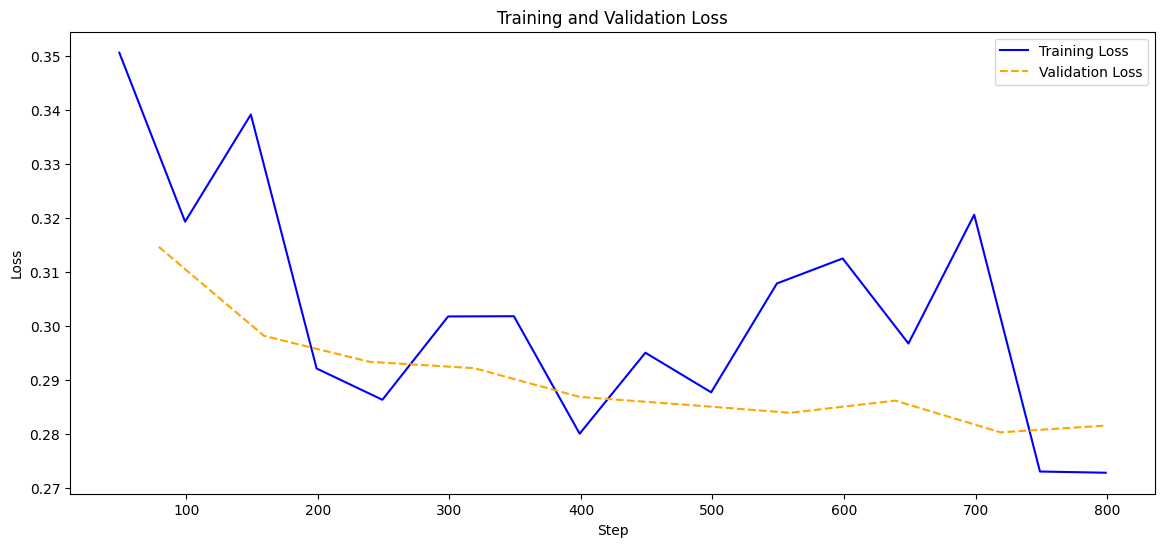

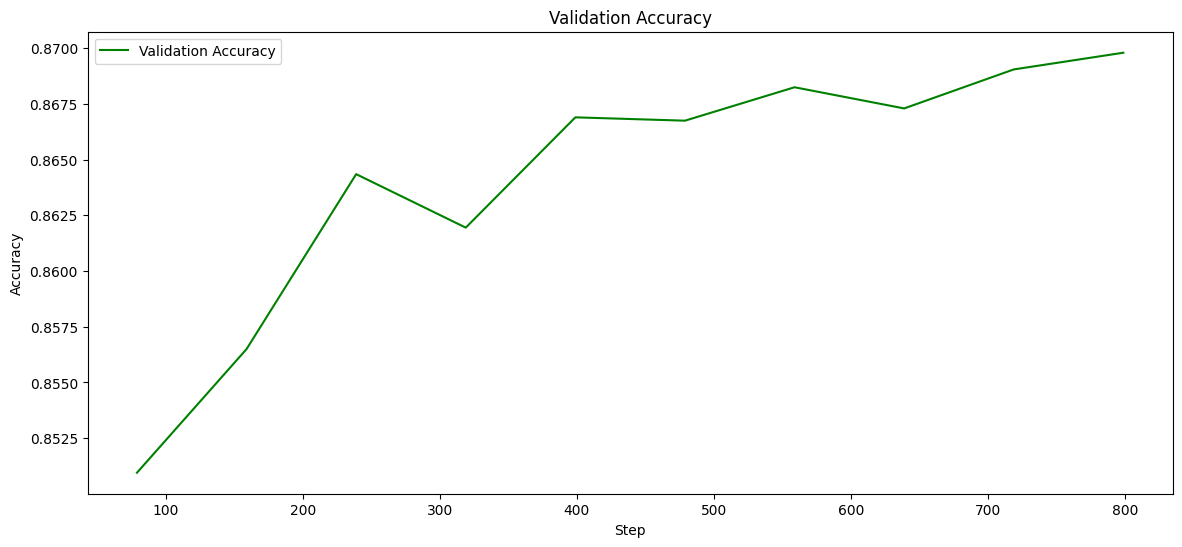

In [32]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the metrics CSV file
metrics = pd.read_csv('logs/tuning_logs6/version_0/metrics.csv')

# Plot training and validation loss
plt.figure(figsize=(14, 6))
plt.plot(metrics['step'][metrics['train_loss'].notna()], metrics['train_loss'].dropna(), label='Training Loss', color='blue')
plt.plot(metrics['step'][metrics['val_loss'].notna()], metrics['val_loss'].dropna(), label='Validation Loss', color='orange', linestyle='--')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot validation accuracy
plt.figure(figsize=(14, 6))
plt.plot(metrics['step'][metrics['val_acc'].notna()], metrics['val_acc'].dropna(), label='Validation Accuracy', color='green')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

# 7)

In [ ]:
# Create DataLoaders for the tuning phase
train_data = HWDataset(x_train, y_train)
valid_data = HWDataset(x_test, y_test)
train_dataloader = DataLoader(train_data, batch_size=500, shuffle=True, num_workers=5)
test_dataloader = DataLoader(valid_data, batch_size=500, shuffle=False, num_workers=5)

In [ ]:
class BigModel(LightningModule):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(28, 1000),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1000, 1000),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1000, 1),
            nn.Sigmoid()  # Use Sigmoid if you're using BCELoss
        )
        self.loss = nn.BCELoss()  # Use BCEWithLogitsLoss if you remove the Sigmoid()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.loss(y_hat.squeeze(), y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.loss(y_hat.squeeze(), y)
        self.log("val_loss", loss)
        acc = accuracy_score(y.detach().cpu(), (y_hat.detach().cpu().squeeze() > 0.5).int())
        self.log("val_acc", acc)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-4)

In [ ]:
csv_logger = CSVLogger(save_dir='logs', name='tuning_logs1')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')

In [ ]:
trainer = Trainer(
    max_epochs=10,
    logger=csv_logger,
    callbacks=[early_stopping],
    devices=1 if torch.cuda.is_available() else 1,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu'
)

model = BigModel()
trainer.fit(model, train_dataloader, test_dataloader)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions on the test set
predictions = []
targets = []

model.eval()
with torch.no_grad():
    for batch in test_dataloader:
        x, y = batch
        y_hat = model(x)
        predictions.extend((y_hat.squeeze() > 0.5).int().tolist())
        targets.extend(y.tolist())

# Plot confusion matrix
cm = confusion_matrix(targets, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the metrics CSV file
metrics = pd.read_csv('logs/tuning_logs1/version_0/metrics.csv')

# Plot training and validation loss
plt.figure(figsize=(14, 6))
plt.plot(metrics['step'][metrics['train_loss'].notna()], metrics['train_loss'].dropna(), label='Training Loss', color='blue')
plt.plot(metrics['step'][metrics['val_loss'].notna()], metrics['val_loss'].dropna(), label='Validation Loss', color='orange', linestyle='--')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot validation accuracy
plt.figure(figsize=(14, 6))
plt.plot(metrics['step'][metrics['val_acc'].notna()], metrics['val_acc'].dropna(), label='Validation Accuracy', color='green')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()